1. Understand the Problem Statement
2. Tweets Preprocessing and Cleaning
  1. Data Inspection
  2. Data Cleaning
3. Story Generation and Visualization from Tweets
4. Extracting Features from Cleaned Tweets
  1. Bag-of-Words
  2. TF-IDF
  3. Word Embeddings
5. Model Building: Sentiment Analysis
  1. Logistic Regression
  2. Support Vector Machine
  3. RandomForest
  4. XGBoost
6. Model Fine-tuning
7. Summary

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
import textblob
from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import os

In [82]:
%matplotlib inline
sns.set(style="darkgrid")
plt.style.use('seaborn')

## 1. Loading the dataset

In [83]:
df=pd.read_csv('Train.csv',encoding="ISO-8859-1")
testdf=pd.read_csv('Test.csv',encoding="ISO-8859-1")

In [84]:
df.head()

,Sentiment,SentimentText
0,1,@coffeebased thanks so much hehe. Will be twe...
1,0,@cakes4rockstarz at least it'd be a delicious...
2,1,@bretharrison Reaper's my favorite show! Kept ...
3,0,@AGraham1206 Lotsa work.... I'm trying to ge...
4,1,@ 4:30 I will Tweet the #Zazzle galleries for ...


In [85]:
#Missing Values If Any
df.isna().sum()

Sentiment        0
SentimentText    0
dtype: int64

In [86]:
print(len(df[df.Sentiment == 0]), 'Negative Tweets')
print(len(df[df.Sentiment == 1]), 'Posistive Tweets')
# Class distribution in this data seems to be imbalanced.
# F1 score should be used fot model performance evaluation in such situation.

34875 Negative Tweets
45123 Posistive Tweets


In [87]:
pd.crosstab(index=df['Sentiment'],columns='count')

col_0,count
Sentiment,
0,34875
1,45123


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

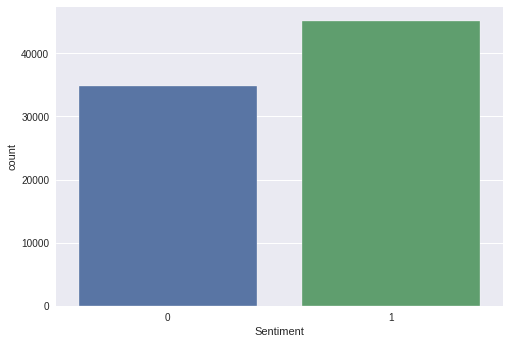

In [89]:
sns.countplot(x='Sentiment', data=df)

### Preprocessing

In [48]:
#importing different libraries for analysis, processing and classification
import nltk
import re #regular expression for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS
from nltk import FreqDist 
# vectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #classification model
from sklearn.metrics import confusion_matrix, classification_report, f1_score # performance evaluation criteria

**Preprocessing the tweet column**

### Removing short words  
We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less. For example, terms like “hmm”, “oh” are of very little use. It is better to get rid of them.

In [97]:
df['SentimentText'] = df['SentimentText'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))


0        @coffeebased thanks tweeting Looking forward r...
1        @cakes4rockstarz delicious frosting didn't cho...
2        @bretharrison Reaper's favorite connected scho...
3        @AGraham1206 work.... trying projects before c...
4                                        #Zazzle galleries
                               ...                        
79993                    @andydick awwwwwwwwwwwwwww missed
79994                                 @alderina definitely
79995                                             everyone
79996                   @Captain_Chrismo thought recommend
79997                          @beckywecks congrats girly!
Name: SentimentText, Length: 79998, dtype: object

In [49]:
def normalizer(tweet):
    tweets = ' '.join(filter(lambda x: x[0] != '@', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets) 
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if not word in set(stopwords.words('english'))]
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = ' '.join(tweets)
    return tweets

In [50]:
%time df['normalized_tweet'] = df.SentimentText.apply(normalizer)

In [53]:
def extract_hashtag(tweet):
    tweets = ' '.join(filter(lambda x: x[0]=='#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]',' ',  tweets)
    tweets = tweets.lower()
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = ''.join(tweets)
    return tweets

In [54]:
df['hashtag'] = df.SentimentText.apply(extract_hashtag)

CPU times: user 1.19 s, sys: 8.1 ms, total: 1.2 s
Wall time: 1.2 s


## 3. Story Generation and Visualization from Tweets

### A) Understanding the common words used in the tweets: WordCloud  
A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

In [57]:
df.head()

,Sentiment,SentimentText,normalized_tweet,hashtag
0,1,@coffeebased thanks so much hehe. Will be twe...,thanks much hehe tweeting lot looking forward ...,
1,0,@cakes4rockstarz at least it'd be a delicious...,least delicious cake cake icky white frosting ...,
2,1,@bretharrison Reaper's my favorite show! Kept ...,reaper favorite show kept connected u school a...,
3,0,@AGraham1206 Lotsa work.... I'm trying to ge...,lotsa work trying get project done thurs confe...,
4,1,@ 4:30 I will Tweet the #Zazzle galleries for ...,tweet zazzle gallery day,zazzle


### D) Understanding the impact of Hashtags on tweets sentiment

In [75]:
freq_all_hashtag = FreqDist(list((" ".join(df.hashtag)).split())).most_common(10)
df_allhashtag = pd.DataFrame(freq_all_hashtag, columns=['words', 'frequency'])

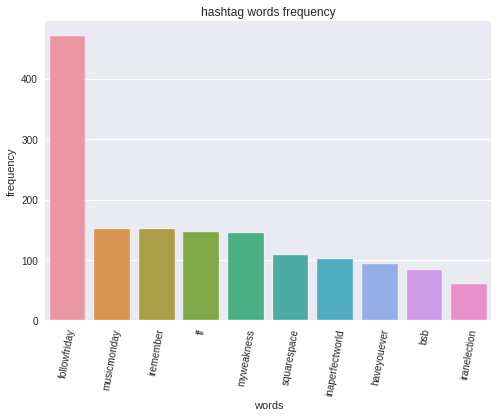

In [74]:
sns.barplot(x='words', y='frequency', data=df_allhashtag)
plt.xticks(rotation = 80)
plt.title('hashtag words frequency')
plt.show()

## 4. Extracting Features from Cleaned Tweets

### 1. Bag-of-words Features

In [ ]:
bow_vectorizer = CountVectorizer(max_df= 0.90, min_df= 2,max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['SentimentText'])
bow.shape

### 2. TF-IDF Features
TF-IDF works by penalising the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

Let’s have a look at the important terms related to TF-IDF:

* TF = (Number of times term t appears in a document)/(Number of terms in the document)

* IDF = log(N/n), where, N is the number of documents and n is the number of documents a term t has appeared in.

* TF-IDF = TF*IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['SentimentText'])
tfidf.shape

## 5. Model Building: Sentiment Analysis

In [99]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#### Bag-of-words features

In [ ]:
train_bow = bow[:31962, :]
test_bow = bow[31962:, :]
# train test split
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],random_state=42,test_size=0.3)

#### TF-IDF features

In [ ]:
train_tfidf = tfidf[:31962, :]
test_tfidf = tfidf[31962:, :]

In [ ]:
classifier1 = MultinomialNB()
classifier1.fit(X_train, y_train)

In [ ]:
y_pred = classifier1.predict(X_test)
y_prob = classifier1.predict_proba(X_test)

In [ ]:
print(f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
model.fit(x_train,y_train)

pred=model.predict(testdf.toarray())

In [ ]:
sub=pd.DataFrame(testdf['ID'])

In [ ]:
sub['Sentiment']=pred

In [ ]:
sub.to_csv('submission.csv')